# Metro Interestate Traffic POC

This notebook will serve as a template for the overall process of taking a non ideal time series dataset and integrating it into [Amazon Forecast](https://aws.amazon.com/forecast/).

## Overview

1. Introduction to Amazon Forecast
1. Obtaining Your Data
1. Fitting the Data to Forecast
1. Determining Your Forecast Horizon (1st pass)
1. Building Your First Few Predictors
1. Visualizing Predictors
1. Making Decisions
1. Adding Related Time Series Data
1. Evaluations Again
1. Next Steps


## Introduction to Amazon Forecast

If you are not familiar with Amazon Forecast you can learn more about this tool on these pages:

* [Product Page](https://aws.amazon.com/forecast/)
* [GitHub Sample Notebooks](https://github.com/aws-samples/amazon-forecast-samples)
* [Product Docs](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. [Wikipedia](https://en.wikipedia.org/wiki/Time_series)
1. [Toward's Data Science Primer](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1. [O'Reilly Book](https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1)

As an exmaple for this POC guide we are going to select a dataset from the UCI repository of machine learning datasets. This is a great tool for finding datasets for various problems. In this particular case it is traffic data for a given section of interstate highway. More information on the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

To begin the cell below will complete the following:

1. Create a directory for the data files.
1. Download the sample data into the directory.
1. Extract the archive file into the directory.

In [1]:
!mkdir poc_data
!cd poc_data && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!gunzip poc_data/Metro_Interstate_Traffic_Volume.csv.gz

--2019-12-28 22:18:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K  1.43MB/s    in 0.3s    

2019-12-28 22:18:35 (1.43 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [229]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [3]:
original_data = pd.read_csv('poc_data/Metro_Interstate_Traffic_Volume.csv')
original_data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


At this point we can see a few things about the data:

* Holidays seem to be specified
* There is a value for temp, rainfall, snowfall, and a few other weather metrics.
* The time series is hourly
* Our value to predict is `traffic_volume down` at the end.

Amazon Forecast relies on a concept called the target-time-series in order to start making predictions, this has a timestamp, an item identifier, and a value. The timestamp is pretty self explanatory, and the value to predict will be traffic_volume, given this is a singular time series an arbitrary item_ID of `1` will be applied later to all entries in the time series file.

The other attributes provided can serve as a basis for related time series components when we get to that much later.

Amazon Forecast also works well to fill in gaps for the target-time-series but not the related data, so before we input our data and get a prediction we should look to see where gaps are, and how we want to structure both inputs to address this issue. 

To get started we will manipulate our starting dataframe to be indexed by the timestamp, drop any duplicated entries and see how much data exists.

Start Date:  2012-10-02 09:00:00
End Date:  2018-09-30 23:00:00


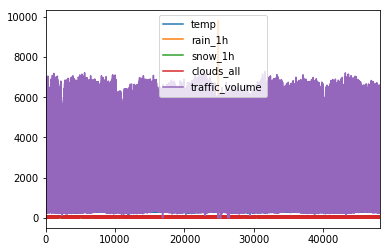

In [4]:
target_df = original_data.copy()
target_df.plot()
print("Start Date: ", min(target_df['date_time']))
print("End Date: ", max(target_df['date_time']))

In [5]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In the cell above we now see a range of October 2012 to nearly October 2018, almost 6 years of hourly data. Given there are around 8700 hours in a year we expect to see 52,000 time series. Immediately here we see 48,204. It looks like some data points are missing, next let us define the index, drop the duplicates and see where we are then.

In [6]:
target_df.set_index('date_time', inplace=True)
target_df = target_df.drop_duplicates(keep ='first')
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48175 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
holiday                48175 non-null object
temp                   48175 non-null float64
rain_1h                48175 non-null float64
snow_1h                48175 non-null float64
clouds_all             48175 non-null int64
weather_main           48175 non-null object
weather_description    48175 non-null object
traffic_volume         48175 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


That change dropped us to 48,175 unique entries. Given this is traffic data we could be dealing with a missing sensor, construction causing outages, or even severe weather delay damaging the recording equipment. Before we decide on how to fill any gaps, let us first take a look to see where they are, and how large the gaps themselves may be.

We will do this by creating a new dataframe for the entire length of the dataset, that has no missing entries, then joining our data to it, and padding out 0's where anything is missing.

*Note* the periods value below is the total number of entriess to make, I cheated and used WolframAlpha to sort out the number of days: https://www.wolframalpha.com/input/?i=days+from+2012-10-02+to+2018-09-30

In [13]:
# Build the index first
idx = pd.DatetimeIndex(freq="h", start="2012-10-02", periods=2190*24)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  from ipykernel import kernelapp as app


In [14]:
full_df = pd.DataFrame(index=idx)
full_df.head(3)

""
2012-10-02 00:00:00
2012-10-02 01:00:00
2012-10-02 02:00:00


In [15]:
print (full_df.index.min())
print (full_df.index.max())

2012-10-02 00:00:00
2018-09-30 23:00:00


In [16]:
# Now perform the join
full_historical_df = full_df.join(target_df, how='outer')
print (full_historical_df.index.min())
print (full_historical_df.index.max())

2012-10-02 00:00:00
2018-09-30 23:00:00


In [17]:
# Take a look at 10 random entries
full_historical_df.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2016-09-25 16:00:00,None,288.86,0.25,0.0,76.0,Rain,light rain,4700.0
2013-10-11 08:00:00,None,287.81,0.00,0.0,1.0,Clear,sky is clear,5810.0
2013-10-18 18:00:00,None,282.14,0.00,0.0,92.0,Rain,light rain,4927.0
2018-08-10 18:00:00,None,303.02,0.00,0.0,1.0,Clear,sky is clear,4616.0
2012-11-28 00:00:00,None,264.18,0.00,0.0,1.0,Clear,sky is clear,510.0
2016-12-22 22:00:00,None,272.27,0.00,0.0,1.0,Clear,sky is clear,2311.0
2015-11-24 20:00:00,None,276.72,0.00,0.0,20.0,Clouds,few clouds,2843.0
2017-07-01 09:00:00,None,291.15,0.00,0.0,1.0,Clear,sky is clear,3257.0
2015-03-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03 08:00:00,None,288.55,0.00,0.0,1.0,Clear,sky is clear,2523.0


At this point we have done enough work to see where we may have any large portions of missing data. To that end we can plot the data below and see any gaps that may crop up.

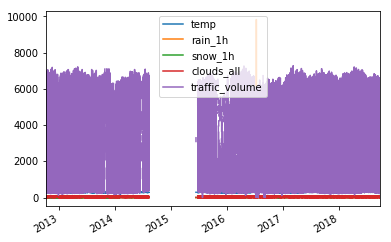

In [19]:
full_historical_df.plot()

Looks like most of 2015 is a total wash for the dataset, we also seem to have a few days missing here and there from 2014, and 2016. To examine this further let us slice the dataframe into unique years and plot them.

2013-01-01 00:00:00
2013-12-31 23:00:00


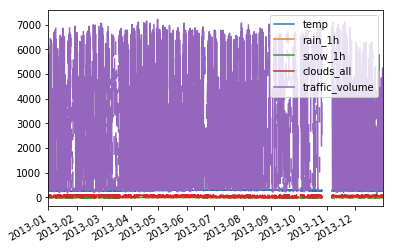

In [20]:
df_2013 = full_historical_df.loc['2013-01-01':'2013-12-31']
print (df_2013.index.min())
print (df_2013.index.max())
df_2013.plot()

2014-01-01 00:00:00
2014-12-31 23:00:00


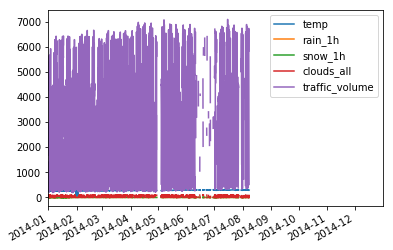

In [21]:
df_2014 = full_historical_df.loc['2014-01-01':'2014-12-31']
print (df_2014.index.min())
print (df_2014.index.max())
df_2014.plot()

2015-01-01 00:00:00
2015-12-31 23:00:00


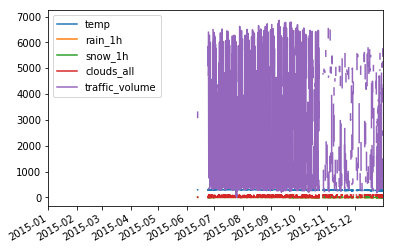

In [22]:
df_2015 = full_historical_df.loc['2015-01-01':'2015-12-31']
print (df_2015.index.min())
print (df_2015.index.max())
df_2015.plot()

2016-01-01 00:00:00
2016-12-31 23:00:00


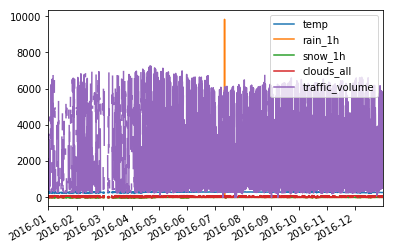

In [23]:
df_2016 = full_historical_df.loc['2016-01-01':'2016-12-31']
print (df_2016.index.min())
print (df_2016.index.max())
df_2016.plot()

2017-01-01 00:00:00
2017-12-31 23:00:00


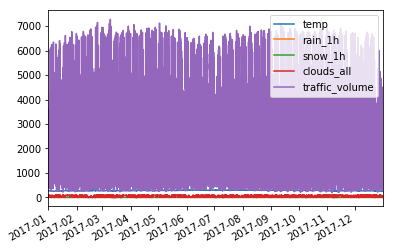

In [24]:
df_2017 = full_historical_df.loc['2017-01-01':'2017-12-31']
print (df_2017.index.min())
print (df_2017.index.max())
df_2017.plot()

2018-01-01 00:00:00
2018-09-30 23:00:00


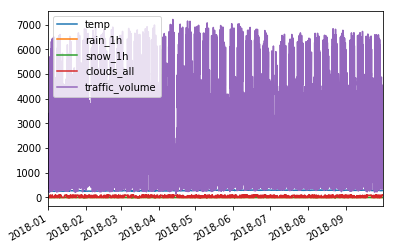

In [25]:
df_2018 = full_historical_df.loc['2018-01-01':'201-12-31']
print (df_2018.index.min())
print (df_2018.index.max())
df_2018.plot()

A few things to note here, clearly we are missing a large volume of data in 2014 and 2015 but also there are some missing patches in 2013 as well. 2016 had spotty data initially but 2017 and 2018 look pretty good.

Given that the data is hourly we still have plenty of it within a single year, and an additional 10 months to use for broader validation if we choose to do that. 

To note, it seems approaches like DeepAR+ and Prophet work very well with > 1k measurements on a given time series. Assuming hourly data (24 measurements per day), that yields around 42 days before we have a solid base of data. Learning over an entire year should be plenty.

Also we need to think about a Forecast horizon or how far into the future we are going to predict at once. Forecast currently limits us to 500 intervals of whatever granularity we have selected. For this exercise we will keep the data hourly and predict 480 hours into the future, or exactly 20 days.

With all of the above spelled out the next thing to do is to build 3. distinct files:

1. `target-time-series.csv` - A CSV file containing our timestamp, item_id, and measurement for the historical period of 2017.
1. `related-time-series.csv` - A CSV file containing our timestamp, item_id, and metadata related to time for both historical 2017, and into the future 2018.
1. `validation-time-series.csv` A CSV file containing our timestamp, item_id, and measurements for 2018 which are not sent to Forecast. This is how we will plot how effective our predictions are (in addition to the metrics provided for our models).

The first 2 files will be used to generated predictions about 2018 and the last will be used to plot performance.

## Building Data Files

Knowing that our above dataframe `full_historical_df` covers the entire time period we care about we start there reducing it to 2017 to end. Then we will use feed forward to plug in any missing holes before splitting into the 3 files described before. 

More info on techniques to patch missing information can be found here: https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.fillna.html 

The risk of filling in values like this is that in smoothing out the data it may cause our predictions to resemble the smoother curve than is our historical data. This is why we selected 2017 to 2018 based on the lack of large gaps in the data.

In [27]:
# Create a copy
targtet_df = full_historical_df.copy()
# Slice to only 2017 onward
targtet_df = targtet_df.loc['2017-01-01':]
# Validate the dates
print (targtet_df.index.min())
print (targtet_df.index.max())

2017-01-01 00:00:00
2018-09-30 23:00:00


In [28]:
# Fill in any missing data with the method ffill
targtet_df.ffill()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-01-01 00:00:00,None,269.75,0.00,0.0,75.0,Clouds,broken clouds,1848.0
2017-01-01 01:00:00,None,269.95,0.00,0.0,1.0,Clear,sky is clear,1806.0
2017-01-01 02:00:00,None,269.75,0.00,0.0,1.0,Clear,sky is clear,1211.0
2017-01-01 03:00:00,None,269.65,0.00,0.0,40.0,Clouds,scattered clouds,794.0
2017-01-01 04:00:00,None,269.48,0.00,0.0,1.0,Clear,sky is clear,500.0
2017-01-01 05:00:00,None,269.22,0.00,0.0,1.0,Clear,sky is clear,513.0
2017-01-01 06:00:00,None,268.90,0.00,0.0,1.0,Clear,sky is clear,821.0
2017-01-01 07:00:00,None,268.34,0.00,0.0,40.0,Clouds,scattered clouds,950.0
2017-01-01 08:00:00,None,267.90,0.00,0.0,1.0,Clear,sky is clear,1284.0
2017-01-01 09:00:00,None,267.71,0.00,0.0,20.0,Clouds,few clouds,2279.0


At this point we have all the data the 3 needed files. 

### Building The Target Time Series File

In [38]:
target_time_series_df = targtet_df.copy()
target_time_series_df = target_time_series_df.loc['2017-01-01':'2017-12-31']
# Validate the date range
print (target_time_series_df.index.min())
print (target_time_series_df.index.max())

2017-01-01 00:00:00
2017-12-31 23:00:00


In [39]:
# Restrict the columns to timestamp, traffic_volume
target_time_series_df = target_time_series_df[['traffic_volume']]
# Add in item_id
target_time_series_df['item_ID'] = "1"
# Validate the structure
target_time_series_df.head()

,traffic_volume,item_ID
2017-01-01 00:00:00,1848.0,1
2017-01-01 01:00:00,1806.0,1
2017-01-01 02:00:00,1211.0,1
2017-01-01 03:00:00,794.0,1
2017-01-01 04:00:00,500.0,1


In [40]:
# With the data in a great state, save it off as a CSV
poc_dir = "poc_data"
target_time_series_filename = "target_time_series.csv"
target_time_series_path = poc_dir + "/" + target_time_series_filename
target_time_series_df.to_csv(target_time_series_path, header=False)

## Building The Related Time Series File

In [230]:
related_time_series_df = targtet_df.copy()
#related_time_series_df = related_time_series_df.loc['2017-01-01':]
# Validate the date range
related_time_series_df.dropna()
related_time_series_df = full_df.join(related_time_series_df, how='outer')
#related_time_series_df.dropna()
#related_time_series_df.fillna(method='ffill')
cols = related_time_series_df.columns.tolist()
related_time_series_df[cols] = related_time_series_df[cols].replace('', np.nan).ffill()
#related_time_series_df.ffill()
related_time_series_df = related_time_series_df.loc['2017-01-01':]
print (related_time_series_df.index.min())
print (related_time_series_df.index.max())

2017-01-01 00:00:00
2018-09-30 23:00:00


In [231]:
related_time_series_df[related_time_series_df.isnull().any(axis=1)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume


# Look at the columns and decide what we should keep:
related_time_series_df.sample(3)

A few things to note here:

* Holidays are not needed given this date is in the US, we can just use the Holidays feature within Forecast: https://docs.aws.amazon.com/forecast/latest/dg/API_SupplementaryFeature.html
* Weather description seems to have more variety
* Traffic volume will be removed here. 
* We still need to add back the item_id field.

This leaves us with the following schema:

* `timestamp` - The Index
* `temp` - float
* `rain_1h` - float
* `snow_1h` - float
* `clouds_all` - float
* `weather_description` - string
* `item_ID` - string

The cell below will build that file for us.


In [232]:
# Restrict the columns to timestamp, traffic_volume
related_time_series_df = related_time_series_df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description']]
# Add in item_id
related_time_series_df['item_ID'] = "1"
# Validate the structure
related_time_series_df.head()


,temp,rain_1h,snow_1h,clouds_all,weather_description,item_ID
2017-01-01 00:00:00,269.75,0.0,0.0,75.0,broken clouds,1
2017-01-01 01:00:00,269.95,0.0,0.0,1.0,sky is clear,1
2017-01-01 02:00:00,269.75,0.0,0.0,1.0,sky is clear,1
2017-01-01 03:00:00,269.65,0.0,0.0,40.0,scattered clouds,1
2017-01-01 04:00:00,269.48,0.0,0.0,1.0,sky is clear,1


In [233]:
related_time_series_df.isnull() 

,temp,rain_1h,snow_1h,clouds_all,weather_description,item_ID
2017-01-01 00:00:00,False,False,False,False,False,False
2017-01-01 01:00:00,False,False,False,False,False,False
2017-01-01 02:00:00,False,False,False,False,False,False
2017-01-01 03:00:00,False,False,False,False,False,False
2017-01-01 04:00:00,False,False,False,False,False,False
2017-01-01 05:00:00,False,False,False,False,False,False
2017-01-01 06:00:00,False,False,False,False,False,False
2017-01-01 07:00:00,False,False,False,False,False,False
2017-01-01 08:00:00,False,False,False,False,False,False
2017-01-01 09:00:00,False,False,False,False,False,False


In [234]:
# Save it off as a file:
related_time_series_filename = "related_time_series.csv"
related_time_series_path = poc_dir + "/" + related_time_series_filename
related_time_series_df.to_csv(related_time_series_path, header=False)

### Building The Validation File

This is the last file we need to build before getting started with Forecast itself. This will be the same in structure as our target-time-series file but will only project into 2018 and includes no historical data from the training data.

In [37]:
validation_time_series_df = targtet_df.copy()
validation_time_series_df = validation_time_series_df.loc['2018-01-01':]
# Validate the date range
print (validation_time_series_df.index.min())
print (validation_time_series_df.index.max())

2018-01-01 00:00:00
2018-09-30 23:00:00


In [41]:
# Restrict the columns to timestamp, traffic_volume
validation_time_series_df = validation_time_series_df[['traffic_volume']]
# Add in item_id
validation_time_series_df['item_ID'] = "1"
# Validate the structure
validation_time_series_df.head()

,traffic_volume,item_ID
2018-01-01 00:00:00,1478.0,1
2018-01-01 01:00:00,1408.0,1
2018-01-01 02:00:00,931.0,1
2018-01-01 03:00:00,585.0,1
2018-01-01 04:00:00,381.0,1


In [42]:
# With the data in a great state, save it off as a CSV
validation_time_series_filename = "validation_time_series.csv"
validation_time_series_path = poc_dir + "/" + validation_time_series_filename
validation_time_series_df.to_csv(validation_time_series_path, header=False)

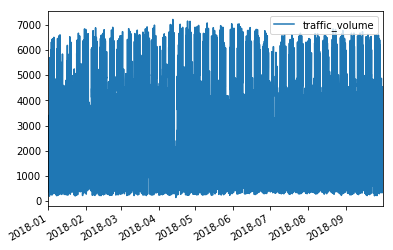

In [43]:
# Also just to get a feel for what it looks like:
validation_time_series_df.plot()

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between DatasetGroups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for our POC.
1. Create a `Target-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.
1. Generate Forecasts with ARIMA, Prophet, and DeepAR+.
1. Query their Forecasts.
1. Plot the Forecasts and metrics. 


At that point we can see which model is best and discuss how to add related data to our POC.

The cell below defines a few global settings for our POC with the service.

In [44]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_hwy_poc'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'

Now using the metada stored on this instance of a SageMaker Notebook determine the region we are operating in. If you are using a Jupyter Notebook outside of SageMaker simply define `region` as the string that indicates the region you would like to use for Forecast and S3.


In [47]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Configure your AWS APIs

In [48]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [49]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [50]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_hwy_poc_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:059124553121:dataset-group/forecast_hwy_poc_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 29, 0, 1, 53, 445000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 29, 0, 1, 53, 445000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '48e7792a-e877-443b-8e6b-bc25321e52e4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 29 Dec 2019 00:01:59 GMT',
   'x-amzn-requestid': '48e7792a-e877-443b-8e6b-bc25321e52e4',
   'content-length': '263',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [51]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [52]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [54]:
target_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_hwy_poc_ds',
 'DatasetName': 'forecast_hwy_poc_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 29, 0, 2, 22, 108000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 29, 0, 2, 22, 108000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'a5ef6abb-86c6-4b6e-867b-5540a352b83a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 29 Dec 2019 00:02:36 GMT',
   'x-amzn-requestid': 'a5ef6abb-86c6-4b6e-867b-5540a352b83a',
   'content-length': '499',
   'connection': 'keep-alive'},
  'RetryAttempts'

In [55]:
# Attach the Dataset to the Dataset Group:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

{'ResponseMetadata': {'RequestId': '6088a259-98a2-43ea-8077-4b8e88956740',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 29 Dec 2019 00:02:59 GMT',
   'x-amzn-requestid': '6088a259-98a2-43ea-8077-4b8e88956740',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

We will also need a Role to interact with S3 and Forecast on our behalf going forward. This cell creates that role.

In [56]:
iam = boto3.client("iam")

role_name = "ForecastRolePOC"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::059124553121:role/ForecastRolePOC


At this point thie next thing to do is import a file into Amazon Forecast, however we do not yet have anything in S3, so we will create a bucket, and upload our target file there. Note this is only the target file.

In [57]:
print(region)
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "forecasthwypoc"
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

us-east-1
059124553121forecasthwypoc


In [58]:
# Upload Target File
boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file(target_time_series_path)
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename

In [59]:
# Finally we can call import the dataset
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [60]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_hwy_poc_ds/DSIMPORT_JOB_TARGET


The cell below will run and poll every 30 seconds until the import process has completed. From there we will be able to create a few models.

In [61]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


# Model building bits

Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on ARIMA, Prophet, and DeepAR+ respectfully.


In [62]:
forecastHorizon = 480
NumberOfBacktestWindows = 4
BackTestWindowOffset = 480
ForecastFrequency = "H"

In [64]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

In [66]:
# ARIMA Specifics
arima_predictorName= project+'_arima_algo_1'

In [69]:
# Build ARIMA:
arima_create_predictor_response=forecast.create_predictor(PredictorName=arima_predictorName, 
                                                  AlgorithmArn=arima_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )



In [70]:
# Prophet Specifics
prophet_predictorName= project+'_prophet_algo_1'

In [71]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=prophet_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )




In [72]:
# DeepAR+ Specifics
prophet_predictorName= project+'_deeparp_algo_1'

In [74]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )





These calls will take an hour or so to complete in full. So feel free to take lunch here, go grab a pint, really anything that is going to kill a decent volume of time.

## Examine the Models

First we are going to get the metrics for each model and see how they stack up:

In [86]:
# ARIMA Metrics
arima_arn = arima_create_predictor_response['PredictorArn']
arima_metrics = forecast.get_accuracy_metrics(PredictorArn=arima_arn)
pp = pprint.PrettyPrinter()
pp.pprint(arima_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2315.5733958045107,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.29069288281337363,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.35619575117523433,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.18638100224895027,
                                                                                          'Quantile': 0.1}]}},
                                             

In [87]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2347.3122950616703,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.28628393129979385,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.3909805496546771,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.157315483033474,
                                                                                          'Quantile': 0.1}]}},
                                              

In [92]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2382.0642289506563,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.3420790501902363,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.29224934682312126,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.10047594736679022,
                                                                                          'Quantile': 0.1}]}},
                                       

## Generate a Forecast For Each

The next phase is to generate a Forecast from each Predictor so we can see the results and understand visually which model is performing better.

In [88]:
# ARIMA
arima_forecastName = project+'_arima_algo_forecast'
arima_create_forecast_response=forecast.create_forecast(ForecastName=arima_forecastName,
                                                  PredictorArn=arima_arn)
arima_forecast_arn = arima_create_forecast_response['ForecastArn']

In [90]:
# Prophet
prophet_forecastName = project+'_prophet_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_forecastName,
                                                  PredictorArn=prophet_arn)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [93]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

## Evaluating the Forecast

Event before exporting the forecasts themselves we can see a few things in the logs above...

Mainly, the RMSE for each model:

1. ARIMA - RMSE: 2315.5733958045107
1. Prophet - RMSE: 2347.3122950616703
1. DeepAR+ - RMSE: 2382.0642289506563

This tells us overall that ARIMA is really behaving more consistently over all of the test windows, however it does not have the lowest error at p50.

Those numbers are:

1. ARIMA wQL[0.5]: 0.3562
1. Prophet wQL[0.5]: 0.3910
1. DeepAR+ wQL[0.5]: 0.2922

This tells us that our DeepAR+ model is doing the best when evaluating the p50 result.

The next stage would be to plot these numbers over a particular window.

To make this particular process easier we are going to export them all as CSV's from the console then read them in later. An improvement would be to use the JSON API and convert to a DF that way.

Note the files were downloaded from an s3 bucket and placed into the `poc_data` folder for exploration.

In [150]:
# ARIMA Eval
arima_predicts = pd.read_csv("poc_data/arima_export_1_2019-12-29T15-13-49Z_part0.csv")
arima_predicts.sample()

,item_id,date,p10,p50,p90
352,1,2018-01-15T16:00:00Z,3836.241773,6330.297385,8824.352997


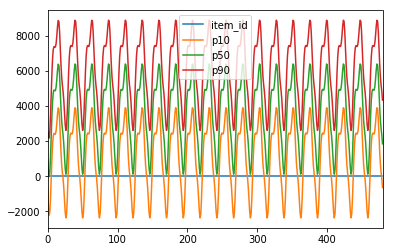

In [151]:
arima_predicts.plot()

In [152]:
# Remove the timezone
arima_predicts['date'] = pd.to_datetime(arima_predicts['date'])

In [153]:

arima_predicts.sample()

,item_id,date,p10,p50,p90
319,1,2018-01-14 07:00:00+00:00,1845.575223,4339.630835,6833.686447


In [155]:
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

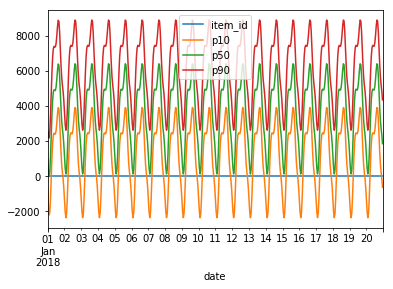

In [156]:
arima_predicts.plot()

In [157]:
print (arima_predicts.index.min())
print (arima_predicts.index.max())

2018-01-01 00:00:00
2018-01-20 23:00:00


Here we can see our prediction goes from Jan 01 to Jan 20 as expectged given our 480 interval forecast horizon. Also we can see the cyclical nature of the predictions over. the entire timeframe. 

Now we are going to create a dataframe of the prediction values from this Forecast and the actual values.

First let us remove the column ID of item before continuing.

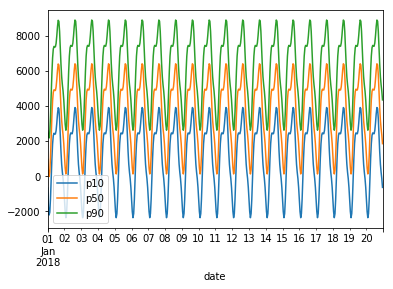

In [158]:
arima_predicts = arima_predicts[['p10', 'p50', 'p90']]
arima_predicts.plot()

In [159]:
# Now strip the timezone information
arima_predicts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2018-01-01 00:00:00 to 2018-01-20 23:00:00
Data columns (total 3 columns):
p10    480 non-null float64
p50    480 non-null float64
p90    480 non-null float64
dtypes: float64(3)
memory usage: 15.0 KB


2018-01-01 00:00:00
2018-01-20 23:00:00


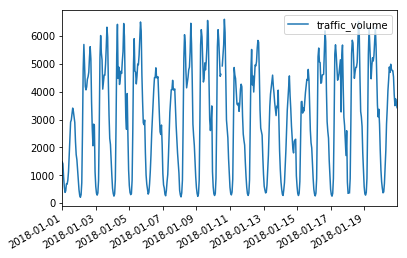

In [160]:
# Lets slice validation to meet our needs
validation_df = validation_time_series_df.copy()
validation_df = validation_df.loc['2018-01-01':'2018-01-20']
print (validation_df.index.min())
print (validation_df.index.max())
validation_df.plot()

In [161]:
# Finally let us join the dataframes together
arima_val_df = arima_predicts.join(validation_df, how='outer')

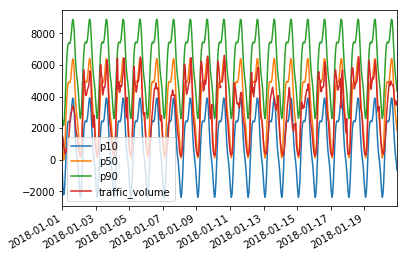

In [162]:
# Plot
arima_val_df.plot()

Given that this particular plot is hard to see, let us pick a random day January 5th to compare.

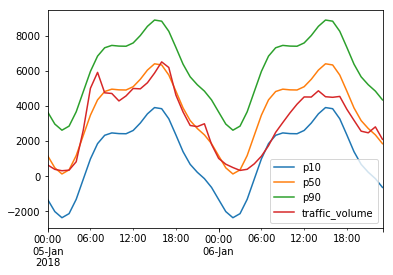

In [163]:
arima_val_df_jan_5 = arima_val_df.loc['2018-01-05':'2018-01-06']
arima_val_df_jan_5.plot()

Now this is pretty clear for p50 showcasing that it does a great job of predicting the volume. Let us now do this for Prophet and DeepAR+.

## Prophet Eval

In [167]:
# Prophet Eval
prophet_predicts = pd.read_csv("poc_data/prophet_export_1_2019-12-29T15-14-18Z_part0.csv")
prophet_predicts.sample()
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date'])
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None)
prophet_predicts.set_index('date', inplace=True)
prophet_predicts = prophet_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
prophet_val_df = prophet_predicts.join(validation_df, how='outer')

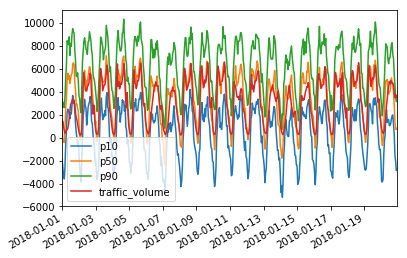

In [168]:
# Plot
prophet_val_df.plot()

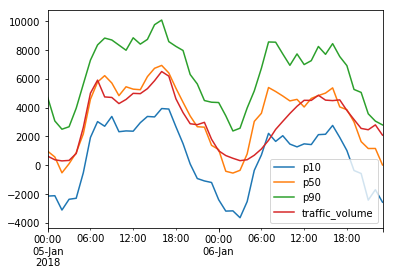

In [169]:
prophet_val_df_jan_5 = prophet_val_df.loc['2018-01-05':'2018-01-06']
prophet_val_df_jan_5.plot()

## DeepAR+ Eval

In [170]:
# DeepAR+ Eval
deeparp_predicts = pd.read_csv("poc_data/deeparp_export_1_2019-12-29T15-14-48Z_part0.csv")
deeparp_predicts.sample()
# Remove the timezone
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date'])
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None)
deeparp_predicts.set_index('date', inplace=True)
deeparp_predicts = deeparp_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
deeparp_val_df = deeparp_predicts.join(validation_df, how='outer')

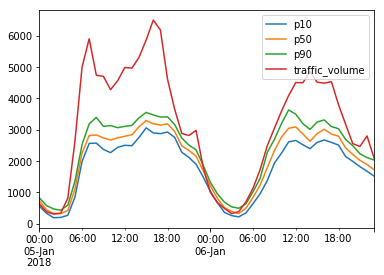

In [171]:
deeparp_val_df_jan_5 = deeparp_val_df.loc['2018-01-05':'2018-01-06']
deeparp_val_df_jan_5.plot()

What is particularly interesting here is that we were below the actual numbers for a good portion of the day even with p90. We did see great performance from Prophet and the metrics indicate that DeepAR+ is objectively better here so now we will add related time series data to our project and see how the models behave then.

## Adding Related Data to the DatasetGroup

In [235]:
# Upload Related File
boto3.Session().resource('s3').Bucket(bucket_name).Object(related_time_series_filename).upload_file(related_time_series_path)
related_s3DataPath = "s3://"+bucket_name+"/"+related_time_series_filename

In [173]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
related_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"temperature",
         "AttributeType":"float"
      },
       {
         "AttributeName":"rain_1h",
         "AttributeType":"float"
      },
       {
         "AttributeName":"snow_1h",
         "AttributeType":"float"
      },
       {
         "AttributeName":"clouds_all",
         "AttributeType":"float"
      },
       {
         "AttributeName":"weather",
         "AttributeType":"string"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [174]:
related_DSN = datasetName + "_related"
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='RELATED_TIME_SERIES',
                    DatasetName=related_DSN,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = related_schema
)

In [175]:
related_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=related_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_hwy_poc_ds_related',
 'DatasetName': 'forecast_hwy_poc_ds_related',
 'Domain': 'CUSTOM',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'temperature', 'AttributeType': 'float'},
   {'AttributeName': 'rain_1h', 'AttributeType': 'float'},
   {'AttributeName': 'snow_1h', 'AttributeType': 'float'},
   {'AttributeName': 'clouds_all', 'AttributeType': 'float'},
   {'AttributeName': 'weather', 'AttributeType': 'string'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 29, 16, 26, 54, 12000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 29, 16, 26, 54, 12000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '31d842e2-63f9-4815-bfe4-7f49778b5a73',
  'HTTPStatusCo

In [236]:
datasetImportJobName = 'DSIMPORT_JOB_RELATED5'
related_ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=related_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":related_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [237]:
rel_ds_import_job_arn=related_ds_import_job_response['DatasetImportJobArn']
print(rel_ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_hwy_poc_ds_related/DSIMPORT_JOB_RELATED5


In [238]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=rel_ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


In [179]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[related_datasetArn, target_datasetArn])

{'ResponseMetadata': {'RequestId': '6cc2d21f-7ce0-4239-b745-61065486c346',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 29 Dec 2019 16:33:10 GMT',
   'x-amzn-requestid': '6cc2d21f-7ce0-4239-b745-61065486c346',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [180]:
# At this point we can now kick off another Prophet and DeepAR+ Model.

In [239]:
# Prophet Specifics
prophet_predictorName= project+'_prophet_algo_rel_1'

In [240]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=prophet_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )




In [241]:
# DeepAR+ Specifics
deeparp_predictorName= project+'_deeparp_algo_rel_1'

In [242]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=deeparp_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )





In [244]:
# DeepAR+ Specifics + HPO
deeparphpo_predictorName= project+'_deeparp_algo_relhpo_1'

In [245]:
# Build DeepAR+:
deeparphpo_create_predictor_response=forecast.create_predictor(PredictorName=deeparphpo_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=True,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )





## Explore Metrics


In [246]:
# Prophet Related Metrics
prophet_rel_arn = prophet_create_predictor_response['PredictorArn']
prophet_rel_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_rel_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_rel_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2280.8806829505147,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.2658487789861532,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.38477963983359187,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.15507416920579198,
                                                                                          'Quantile': 0.1}]}},
                                            

In [247]:
# DeepAR+ Metrics
deeparp_rel_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_rel_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_rel_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_rel_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2227.222415029805,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.23694539297177075,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.29187385268911265,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.12179354302097159,
                                                                                          'Quantile': 0.1}]}},
                                       

From the RMSEs we are seeing an improvement for both models, at this point the cells below will again generate an export of the data so we can plot it.

In [248]:
# Prophet
prophet_rel_forecastName = project+'_prophet_rel_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_rel_forecastName,
                                                  PredictorArn=prophet_rel_arn)
prophet_rel_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [249]:
# DeepAR+
deeparp_rel_forecastName = project+'_deeparp_rel_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_rel_forecastName,
                                                  PredictorArn=deeparp_rel_arn)
deeparp_rel_forecast_arn = deeparp_create_forecast_response['ForecastArn']

## Evaluating the Forecast

Event before exporting the forecasts themselves we can see a few things in the logs above...

Mainly, the RMSE for each model without related data:

1. ARIMA - RMSE: 2315.5733958045107
1. Prophet - RMSE: 2347.3122950616703
1. DeepAR+ - RMSE: 2382.0642289506563

With related time series data Prophet and DeepAR+ shift to:

1. Prophet - RMSE: 2280.8806829505147
1. DeepAR+ - RMSE: 2227.222415029805

Objectively we now see DeepAR+ outperforming ARIMA as well as Prophet for this particular problem.

The original wQL[0.5]'s are:

1. ARIMA wQL[0.5]: 0.3562
1. Prophet wQL[0.5]: 0.3910
1. DeepAR+ wQL[0.5]: 0.2922

With the related time series data we now see:

1. Prophet wQL[0.5]: 0.3848
1. DeepAR+ wQL[0.5]: 0.2919

At this point DeepAR+ is also scoring higher here by having a smaller weighted loss at this quantile. As for absolutes, it wins in every weighted quantile but DeepAR+'s performance at .1 without related time series data, this was a slight performance drop however. Another job continues to run that will explore the impact of HPO with the goal of besting 0.1005 at wQL[0.1].

This tells us that our DeepAR+ model is doing the best when evaluating the p50 result.

The next stage would be to plot these numbers over a particular window.

To make this particular process easier we are going to export them all as CSV's from the console then read them in later. An improvement would be to use the JSON API and convert to a DF that way.

Note the files were downloaded from an s3 bucket and placed into the `poc_data` folder for exploration.

### Evaluating Prophet:

In [279]:
# Prophet Related Eval
prophet_rel_predicts = pd.read_csv("poc_data/prophet_rel_1_2019-12-30T02-36-39Z_part0.csv")
prophet_rel_predicts.sample()

,item_id,date,weather,p10,p50,p90
191,1,2018-01-08T23:00:00Z,sky is clear,-1615.852935,1205.697889,4095.072446


In [ ]:
# Remove the timezone
prophet_rel_predicts['date'] = pd.to_datetime(prophet_rel_predicts['date'])
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

## Plotting it all together

Lastly we will take a look at our p50 prediction from ARIMA, Prophet, and DeepAR+ where the latter leverage related time series data to see how close they are over our validation period.


In [272]:
validation_df_final = validation_time_series_df.copy()
validation_df_final = validation_df_final[['traffic_volume']]
# Just plotting a week
validation_df_final = validation_df_final.loc['2018-01-01':'2018-01-05']
arima_p50 = arima_predicts[['p50']]
arima_p50 = arima_p50.loc['2018-01-01':'2018-01-05']
validation_df_final.rename(columns = {'traffic_volume':'ACTUAL'}, inplace = True)
arima_p50.rename(columns = {'p50':'ARIMA_P50'}, inplace = True)

In [273]:
validation_df_final.head()

,ACTUAL
2018-01-01 00:00:00,1478.0
2018-01-01 01:00:00,1408.0
2018-01-01 02:00:00,931.0
2018-01-01 03:00:00,585.0
2018-01-01 04:00:00,381.0


In [274]:
arima_p50.head()

,ARIMA_P50
date,
2018-01-01 00:00:00,941.030828
2018-01-01 01:00:00,290.743621
2018-01-01 02:00:00,-28.349884
2018-01-01 03:00:00,229.145611
2018-01-01 04:00:00,1064.606165


In [275]:
validation_df_final = validation_df_final.join(arima_p50, how='outer')

In [276]:
validation_df_final.head()

,ACTUAL,ARIMA_P50
2018-01-01 00:00:00,1478.0,941.030828
2018-01-01 01:00:00,1408.0,290.743621
2018-01-01 02:00:00,931.0,-28.349884
2018-01-01 03:00:00,585.0,229.145611
2018-01-01 04:00:00,381.0,1064.606165


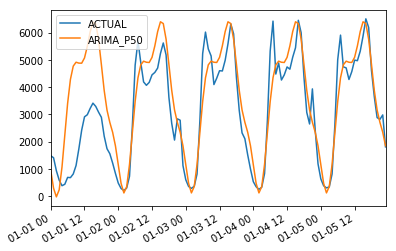

In [277]:
validation_df_final.plot()